In [1]:
from langchain_google_community import BigQueryLoader
from google.cloud import bigquery
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage
from langchain_google_vertexai import ChatVertexAI
from langgraph.graph import Graph, END
from typing import TypedDict, Annotated, Union, Optional
import pandas as pd
import json
import os
import re
import re
import warnings
warnings.filterwarnings("ignore")

# Set up credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/mncedisimncwabe/Downloads/hallowed-span-459710-s1-c41d79c9b56b.json"

# Initialize BigQuery client
client = bigquery.Client()

def get_all_schemas(dataset_id):
    """Fetch schemas for all tables in the dataset"""
    tables = client.list_tables(dataset_id)
    schemas = {}
    
    for table in tables:
        try:
            table_ref = client.get_table(table)
            schemas[table.table_id] = [
                {
                    "name": field.name,
                    "type": field.field_type,
                    "description": field.description or "No description"
                }
                for field in table_ref.schema
            ]
        except Exception as e:
            print(f"Error fetching schema for {table.table_id}: {str(e)}")
    
    return schemas

# Get all schemas
schemas = get_all_schemas("test_clustering")
print("All Table Schemas:")
print(json.dumps(schemas, indent=2))

All Table Schemas:
{
  "dim_date": [
    {
      "name": "date",
      "type": "STRING",
      "description": "No description"
    },
    {
      "name": "year",
      "type": "INTEGER",
      "description": "No description"
    },
    {
      "name": "month",
      "type": "INTEGER",
      "description": "No description"
    },
    {
      "name": "week",
      "type": "INTEGER",
      "description": "No description"
    },
    {
      "name": "month_name",
      "type": "STRING",
      "description": "No description"
    }
  ],
  "fact_user_metrics": [
    {
      "name": "user_id",
      "type": "INTEGER",
      "description": "No description"
    },
    {
      "name": "country",
      "type": "STRING",
      "description": "No description"
    },
    {
      "name": "Tenure_Grp",
      "type": "STRING",
      "description": "No description"
    },
    {
      "name": "avg_engagement_rate",
      "type": "FLOAT",
      "description": "No description"
    },
    {
      "name": "tot

In [7]:
# Initialize Vertex AI LLM
llm = ChatVertexAI(
    model_name="gemini-2.0-flash-001",
    temperature=0, # Controls the randomness/creativity of the AI's output. With higher values, it might sometimes add unnecessary clauses.
    max_output_tokens=2048, # Set the maximum length of the generated response in tokens (≈ words/word parts). 1,500-2,000 words
    project="hallowed-span-459710-s1",
    location="us-central1"
)

def format_schema_for_prompt(schema_data):
    """Format schema data for human-readable prompt"""
    formatted = []
    for table_name, columns in schema_data.items():
        formatted.append(f"Table {table_name}:")
        for col in columns:
            formatted.append(f"  - {col['name']} ({col['type']}): {col['description']}")
    return "\n".join(formatted)

# agent instructions prompt 
system_prompt = f"""You are an advanced BigQuery SQL expert with data modeling intuition. Key capabilities:

1. Schema Reasoning:
- Automatically detect date fields that should join to dim_date (e.g., first_seen_date → dim_date.date)
- Recognize common patterns (user_id for joins, *_date for time dimensions)
- Identify fact vs dimension tables based on structure

2. Intelligent Defaults:
- For time-based questions, default to appropriate date granularity (month/quarter/year)
- For user metrics, consider both raw (user-engagement) and aggregated (fact_user_metrics) sources
- When counting distinct values, automatically add LIMIT based on expected cardinality

3. Self-Correction:
- If initial query returns unexpected zeros/null values:
  1. Check date formatting
  2. Verify join conditions
  3. Consider alternative source tables

4. Analytical Best Practices:
- Prefer COUNT(DISTINCT) over COUNT() for user metrics
- Use appropriate date functions (EXTRACT, DATE_TRUNC)
- Apply CASE WHEN for conditional logic

Available tables:
{format_schema_for_prompt(schemas)}

Examples of Intelligent Behavior:
Q: "How many unique months per user?"
A: SELECT 
     u.user_id,
     COUNT(DISTINCT FORMAT_DATE('%Y-%m', d.date)) AS unique_months
   FROM `hallowed-span-459710-s1.test_clustering.user-engagement` u
   JOIN `hallowed-span-459710-s1.test_clustering.dim_date` d 
     ON u.first_seen_date = d.date
   GROUP BY u.user_id

Q: "Find users active in Q2 but not Q3"
A: WITH q2_users AS (
     SELECT DISTINCT user_id 
     FROM `hallowed-span-459710-s1.test_clustering.user-engagement` u
     JOIN `hallowed-span-459710-s1.test_clustering.dim_date` d 
       ON u.first_seen_date = d.date
     WHERE d.quarter = 'Q2'
   )
   SELECT q2.user_id
   FROM q2_users q2
   WHERE NOT EXISTS (
     SELECT 1 
     FROM `hallowed-span-459710-s1.test_clustering.user-engagement` u2
     JOIN `hallowed-span-459710-s1.test_clustering.dim_date` d2 
       ON u2.first_seen_date = d2.date
     WHERE d2.quarter = 'Q3'
     AND u2.user_id = q2.user_id
   )
"""

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{question}")
])

# Define the agent state
class AgentState(TypedDict):
    question: str # Never loses original request
    sql_query: Optional[str]  # Tracks all query versions
    query_result: Union[pd.DataFrame, str, None]
    validation_errors: list[str]
    attempts: int # Limits retries
    needs_correction: bool

# Helper function to clean SQL query
def clean_sql_query(query: str) -> str:
    """Clean and normalize SQL query by removing backticks, etc."""
    if query is None:
        return ""
    if query.startswith("```") and query.endswith("```"):
        query = query.strip("`")
        if query.lower().startswith("sql"):
            query = query[3:].strip()
    return query.strip()

# Initialize the graph
workflow = Graph()

# Define nodes
def generate_sql(state: AgentState):
    # LLM generates SQL query
    print(f"\nGenerating SQL for: {state['question']}")
    chain = (
        {"question": lambda x: x["question"]}
        | prompt_template
        | llm
        | StrOutputParser()
    )
    sql_query = chain.invoke(state)
    print(f"Generated SQL (raw): {sql_query}")
    return {
        "sql_query": sql_query, 
        "attempts": state.get("attempts", 0) + 1,
        "query_result": None,  # Initialize query_result
        "validation_errors": []  # Initialize validation_errors
    }

def validate_sql(state: AgentState):
    query = clean_sql_query(state["sql_query"])
    errors = []
    
    # Validation checks
    if not query.lower().startswith(("select", "with")):
        errors.append("Must start with SELECT/WITH")
    
    if not re.search(r"(`hallowed-span-459710-s1\.test_clustering\.[a-zA-Z0-9_-]+`|`[a-zA-Z0-9_-]+`)", query, re.IGNORECASE):
        errors.append("Missing valid table reference")
    
    if "join" in query.lower() and not re.search(r"\bjoin\b(.|\n)+?\bon\b", query, re.IGNORECASE):
        errors.append("JOIN missing ON clause")
    
    return {
        "validation_errors": errors, 
        "sql_query": state["sql_query"],
        "query_result": None  
    }

def execute_query(state: AgentState):
    if state["validation_errors"]:
        print(f"Validation errors: {state['validation_errors']}")
        return {
            "query_result": f"Validation errors: {', '.join(state['validation_errors'])}",
            "sql_query": state["sql_query"],
            "needs_correction": True
        }
    
    query = clean_sql_query(state["sql_query"])
    print(f"Executing query: {query}")
    try:
        query_job = client.query(query)
        result = query_job.result().to_dataframe()
        return {
            "query_result": result,
            "sql_query": state["sql_query"],
            "needs_correction": False
        }
    except Exception as e:
        return {
            "query_result": f"Execution Error: {str(e)}",
            "sql_query": state["sql_query"],
            "needs_correction": True
        }

def analyze_results(state: AgentState):
    result_update = {
        "sql_query": state["sql_query"],
        "query_result": state["query_result"]
    }
    
    if isinstance(state["query_result"], str):
        print(f"Problem detected: {state['query_result']}")
        result_update["needs_correction"] = True
        return result_update
    
    if isinstance(state["query_result"], pd.DataFrame):
        if state["query_result"].empty:
            result_update["needs_correction"] = True
            result_update["query_result"] = "Query returned empty results"
        elif (state["query_result"].iloc[:, 1:] == 0).all().all():
            result_update["needs_correction"] = True
            result_update["query_result"] = "Query returned all zeros"
        else:
            result_update["needs_correction"] = False
    
    return result_update

def correct_query(state: AgentState):
    # Uses LLM + past error to improve SQL
    error_context = state.get("query_result", "Unknown error")
    original_query = state.get("sql_query", "No query generated yet")
    print(f"\nAttempting to correct query. Error: {error_context}")
    
    correction_prompt = f"""Correct this SQL query based on the error:
    
    Error: {error_context}
    Original Query: {original_query}
    
    Question: {state['question']}
    
    Please provide the corrected SQL query only:"""
    
    corrected = llm.invoke(correction_prompt)
    return {
        "sql_query": corrected.content.strip(),
        "attempts": state.get("attempts", 0),
        "query_result": None,
        "validation_errors": []
    }

# Add nodes to the graph
workflow.add_node("generate", generate_sql)
workflow.add_node("validate", validate_sql)
workflow.add_node("execute", execute_query)
workflow.add_node("analyze", analyze_results)
workflow.add_node("correct", correct_query)

# Set up edges
workflow.set_entry_point("generate")
workflow.add_edge("generate", "validate")
workflow.add_edge("validate", "execute")
workflow.add_edge("execute", "analyze")

# Conditional edges
workflow.add_conditional_edges(
    "analyze",
    lambda x: "correct" if x["needs_correction"] and x.get("attempts", 0) < 3 else END,
    {"correct": "correct", "__end__": END}
)
workflow.add_edge("correct", "validate")

# Compile the graph
app = workflow.compile()

def bigquery_agent(question: str, max_attempts: int = 3) -> Union[pd.DataFrame, str]:
    state = {
        "question": question,
        "sql_query": None,
        "query_result": None,
        "validation_errors": [],
        "attempts": 0,
        "needs_correction": False
    }
    
    for attempt in range(max_attempts):
        print(f"\nAttempt {attempt + 1}/{max_attempts}")
        state = app.invoke(state)
        
        if not state.get("needs_correction", False):
            result = state["query_result"]
            if isinstance(result, pd.DataFrame):
                return result
            else:
                return f"Final result: {result}"
    
    return state.get("query_result", "Max attempts reached without success")

# Test questions
questions = [
    "How many unique months does each user have, order in descending order?",
    "Show monthly engagement trends by country",
    "Compare average engagement between MoMo users and non-users",
    "What's the distribution of users across tenure groups by country?"
]

for question in questions:
    print(f"\n{'='*50}\nProcessing: {question}\n{'='*50}")
    result = bigquery_agent(question)
    
    print("\nFinal Result:")
    if isinstance(result, pd.DataFrame):
        print(result.head())
    else:
        print(result)


Processing: How many unique months does each user have, order in descending order?

Attempt 1/3

Generating SQL for: How many unique months does each user have, order in descending order?
Generated SQL (raw): ```sql
SELECT 
    user_id,
    COUNT(DISTINCT EXTRACT(MONTH FROM PARSE_DATE('%Y-%m-%d', first_seen_date))) AS unique_months
FROM
    `hallowed-span-459710-s1.test_clustering.user-engagement`
GROUP BY
    user_id
ORDER BY
    unique_months DESC
LIMIT 100
```
Executing query: SELECT 
    user_id,
    COUNT(DISTINCT EXTRACT(MONTH FROM PARSE_DATE('%Y-%m-%d', first_seen_date))) AS unique_months
FROM
    `hallowed-span-459710-s1.test_clustering.user-engagement`
GROUP BY
    user_id
ORDER BY
    unique_months DESC
LIMIT 100

Final Result:
        user_id  unique_months
0  237673281876              1
1  237672774426              1
2  237682352476              1
3  237688502382              1
4  237678436361              1

Processing: Show monthly engagement trends by country

Attempt 1

### LangGraph

LangChain Handles LLM Interactions:

- Generates the initial SQL

- Powers the correction mechanism

- Formats prompts with schema context

LangGraph Manages the Process:

- Retries failed queries with full context

- Maintains state (attempts, errors, last query)

- Decides when to terminate


Flow:
##### 1. User query:
- User types a question e.g Monthly active users by country
- LLM (Gemini) uses the schema-aware prompt (system_promot) to pick correct tables/columns then generates raw SQL query

##### 2. SQL Cleaning:
- LLMs often wrap SQL in markdown e.g (```sql SELECT ....) BigQuery would reject markdown-formatted SQL, so this standardizes input for validation
- clean_sql_query() removes formatting to SELECT ...

##### 3. Validation (Guardrails)
- It then checks for critical errors before execution: e.g Valid table references to prevent "table not found" errors or any other syntax errors

##### 4. BigQuery Execution
- Sends cleaned SQL to BigQuery then return an output of that query in pandas format table

##### 5. SQL Query Results Analysis
- Checks for semantic issues the validator couldn't catch: e.g empty results , all zeros results 

##### 6. Self-Correction Loop
- If any suspicious results or execution failures were found, contextual feedback will be sent back to the LLM to correct
e.g what the LLM would receive "Fix this: Execution Error: Unrecognized column 'last_active_date'. Valid columns: ['user_id', 'signup_date', ...]
- LLM Outputs revised SQL query then restarts from validation

##### 7. Final Output
- Returns pandas DataFrame (ready for visualization)

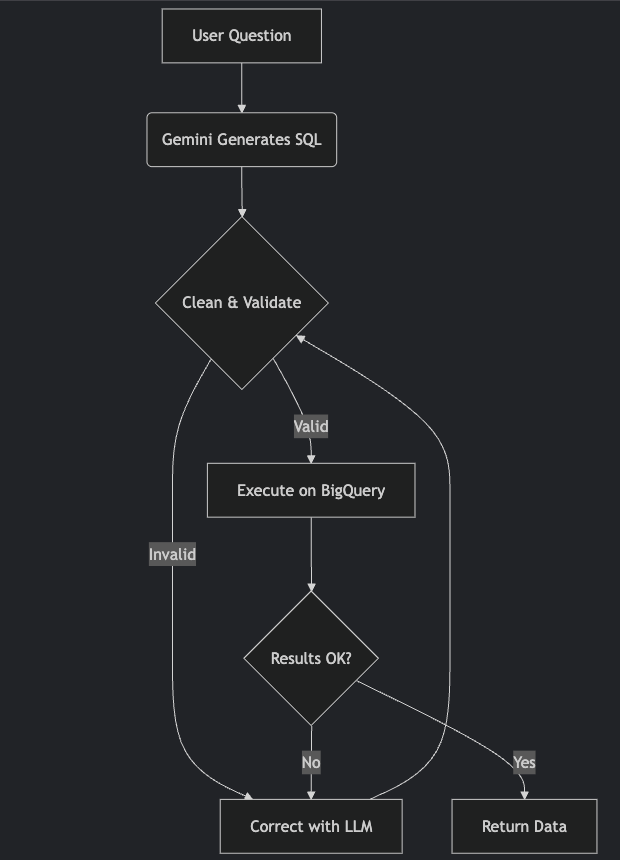

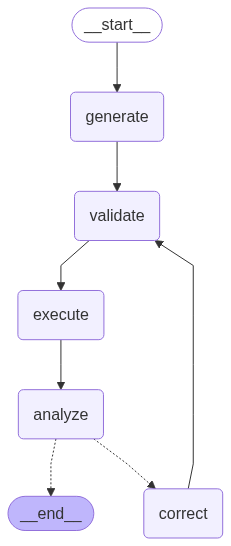

In [6]:
app